In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Visual configuration
sns.set(style="whitegrid")
%matplotlib inline
warnings.filterwarnings('ignore')

print("Libraries imported correctly.")

Libraries imported correctly.


In [16]:
# Data upload
archive = '/content/base_usuario_encoprac2022.txt'

try:
    df = pd.read_csv(archive, sep='|', low_memory=False)
    print(f"Database loaded. Total number of rows: {len(df)}")

except FileNotFoundError:
    print(f"ERROR: Can't find '{archive}'. Please check the file name and upload it again.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Variable selection

cols = [
    'SEXO_SEL', 'EDAD_SEL', 'NIVEL_EDUCATIVO_SEL', 'COBERTURA_SEL',
    'SA_03', 'SA_05',      # <--- Percieved health and previous mental health consultations
    'PV_AL', 'PV_TA',      # <--- Alcohol and tobacco consumption in life.
    'PR_06_3A',            # <--- Percieved risk of taking tranquilizers without perscription
    'PV_TR',               # <--- Life prevalence of consumption of tranquilizers
    'TRS_01'               # <--- Life prevalence of onsumption of tranquilizers without prescription
]

data = df[cols].copy()

# Renamed variables
names = {
    'SEXO_SEL': 'Sex',
    'EDAD_SEL': 'Age',
    'NIVEL_EDUCATIVO_SEL': 'Level_of_education',
    'COBERTURA_SEL': 'Health_coverage',
    'SA_03': 'Self_perceived_health',
    'SA_05': 'Mental_Health_Consultation',
    'PV_AL': 'Alcohol_Consumption_Life',
    'PV_TA': 'Tobacco_Consumptiom_Life',
    'PR_06_3A': 'Risk_Perception',
    'PV_TR': 'General_Consumption_Target',
    'TRS_01': 'No_Prescription_Consumption_Target'
}
data = data.rename(columns=names)

# Target variable normalization
data['No_Prescription_Consumption_Target'] = data['No_Prescription_Consumption_Target'].replace({2: 0})

print("Variables selected")
data.head()

Database loaded. Total number of rows: 12062
Variables selected


,Sex,Age,Level_of_education,Health_coverage,Self_perceived_health,Mental_Health_Consultation,Alcohol_Consumption_Life,Tobacco_Consumptiom_Life,Risk_Perception,General_Consumption_Target,No_Prescription_Consumption_Target
0,1,27,4,2,3,2,1,1,4,0,0
1,1,33,6,2,4,2,1,1,3,0,0
2,2,19,4,1,5,2,1,1,2,0,0
3,2,51,6,1,4,2,1,1,4,0,0
4,1,31,5,1,5,2,1,1,3,0,0


In [17]:
# Handling missing values.
# Non-response codes
nulos = [98, 99, 998, 999, 5]
data = data.replace(nulos, np.nan)

print(f"Original rows: {len(data)}")
data = data.dropna()
print(f"Clean rows for model: {len(data)}")


# Feature preparation
data['Risk_Perception'] = data['Risk_Perception'].astype(float)

cats = ['Sex', 'Level_of_education', 'Self_perceived_health', 'Mental_Health_Consultation',
        'Health_coverage', 'Mental_Health_Consultation',
        'Tobacco_Consumptiom_Life', 'Alcohol_Consumption_Life']

X = pd.get_dummies(data.drop(['General_Consumption_Target', 'No_Prescription_Consumption_Target'], axis=1),
                   columns=cats, drop_first=True)

print(f"Variables listas: {X.shape[1]}")

Original rows: 12062
Clean rows for model: 7263
Variables listas: 17


In [18]:
def train_model(target_name, model_label, use_smote=False):
    # 1. Define y
    y = data[target_name]

    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. SMOTE BLOCK
    if use_smote:
        print(f"Applying SMOTE to: {model_label}...")
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"  -> Positive cases increased to: {sum(y_train)} (Balanced)")

    # 4. Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=10,
                                class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)

    # 5. Prediction with DYNAMIC THRESHOLD
    if use_smote:
        # Get raw probabilities (0.0 to 1.0)
        y_proba = rf.predict_proba(X_test)[:, 1]

        # DEBUG: Print the top 10 highest probabilities the model found
        print(f"  [DEBUG] Max probabilities found: {sorted(y_proba, reverse=True)[:10]}")

        # AGGRESSIVE THRESHOLD:
        # Set it very low (e.g., 0.15). If the model suspects even 15%, we flag it.
        threshold = 0.15
        y_pred = (y_proba >= threshold).astype(int)
        print(f"  -> Using aggressive threshold: {threshold}")
    else:
        y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    # Report
    print(f"\nResults for: {model_label}")
    print("-" * 50)
    print(f"Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred))

    # Feature Importance
    imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_,
        'Model': model_label
    })
    return imp

In [19]:
print("--- TRAINING COMPARATIVE MODELS ---")
imp_gen = train_model('General_Consumption_Target', 'General Consumption (Medical)', use_smote=False)
imp_sin = train_model('No_Prescription_Consumption_Target', 'Non-Prescription Use (SMOTE)', use_smote=True)

--- TRAINING COMPARATIVE MODELS ---

Results for: General Consumption (Medical)
--------------------------------------------------
Accuracy: 75.09%
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1178
           1       0.38      0.51      0.44       275

    accuracy                           0.75      1453
   macro avg       0.63      0.66      0.64      1453
weighted avg       0.78      0.75      0.76      1453

Applying SMOTE to: Non-Prescription Use (SMOTE)...
  -> Positive cases increased to: 5692.0 (Balanced)
  [DEBUG] Max probabilities found: [np.float64(0.8297195373061398), np.float64(0.821182554176081), np.float64(0.8045181545453326), np.float64(0.80048849344421), np.float64(0.7709753265191243), np.float64(0.7709753265191243), np.float64(0.7594848369576497), np.float64(0.7587054150414109), np.float64(0.7582880168385278), np.float64(0.7520891312362608)]
  -> Using aggressive threshold: 0.15

Results for: Non-Prescription 

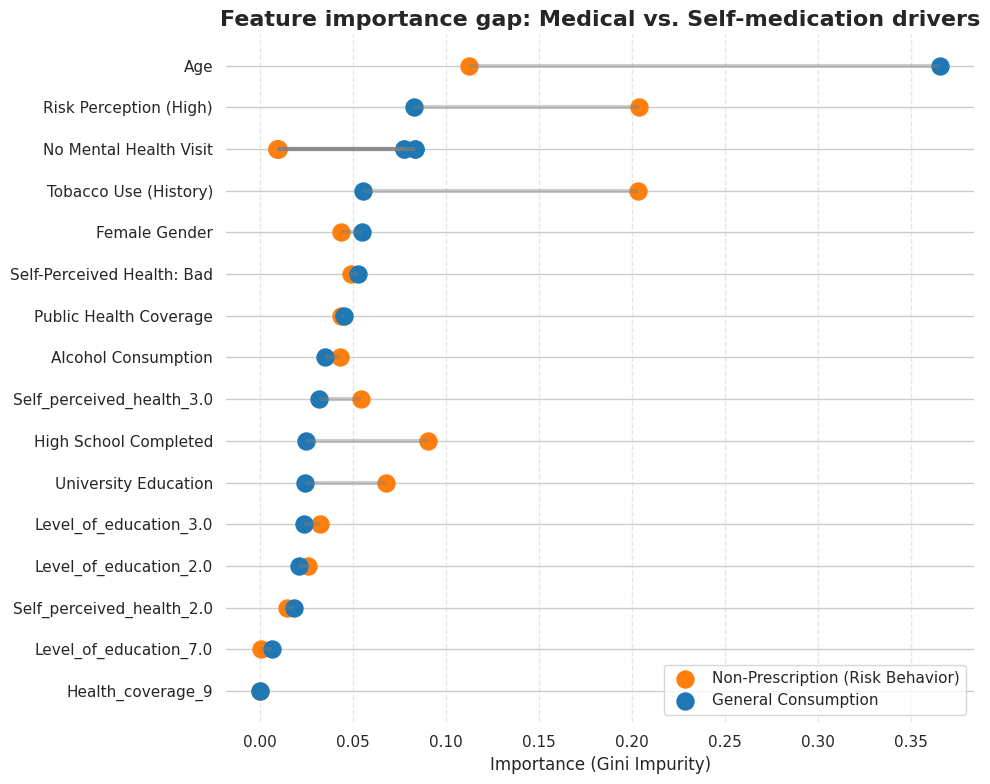

In [20]:
# Chart 1: Dumbell on feature importance
# Merge dataframes
df_chart = pd.merge(imp_gen, imp_sin, on='Feature', suffixes=('_Gen', '_NonPre'))
df_chart = df_chart.sort_values('Importance_Gen', ascending=True)

# Translation of technical codes to professional english)
labels_map = {
    'Age': 'Age',
    'Mental_Health_Consultation_2.0': 'No Mental Health Visit',
    'Risk_Perception': 'Risk Perception (High)',
    'Self_perceived_health_4.0': 'Self-Perceived Health: Bad',
    'Sex_2': 'Female Gender',
    'Tobacco_Consumptiom_Life_1': 'Tobacco Use (History)',
    'Health_coverage_2': 'Public Health Coverage',
    'Alcohol_Consumption_Life_1': 'Alcohol Consumption',
    'Level_of_education_6.0': 'University Education',
    'Level_of_education_4.0': 'High School Completed'
}

# Apply renaming only if the feature exists in top list
df_chart['Label'] = df_chart['Feature'].map(labels_map).fillna(df_chart['Feature'])

# Plot
plt.figure(figsize=(10, 8))

# Lines
plt.hlines(y=df_chart['Label'],
           xmin=df_chart['Importance_NonPre'],
           xmax=df_chart['Importance_Gen'],
           color='grey', alpha=0.4, linewidth=3)

# Dots
plt.scatter(df_chart['Importance_NonPre'], df_chart['Label'],
            color='#ff7f0e', alpha=1, s=150, label='Non-Prescription (Risk Behavior)')
plt.scatter(df_chart['Importance_Gen'], df_chart['Label'],
            color='#1f77b4', alpha=1, s=150, label='General Consumption')


plt.title('Feature importance gap: Medical vs. Self-medication drivers', fontsize=16, weight='bold')
plt.xlabel('Importance (Gini Impurity)', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
sns.despine(left=True, bottom=True)
plt.grid(axis='x', color='grey', alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

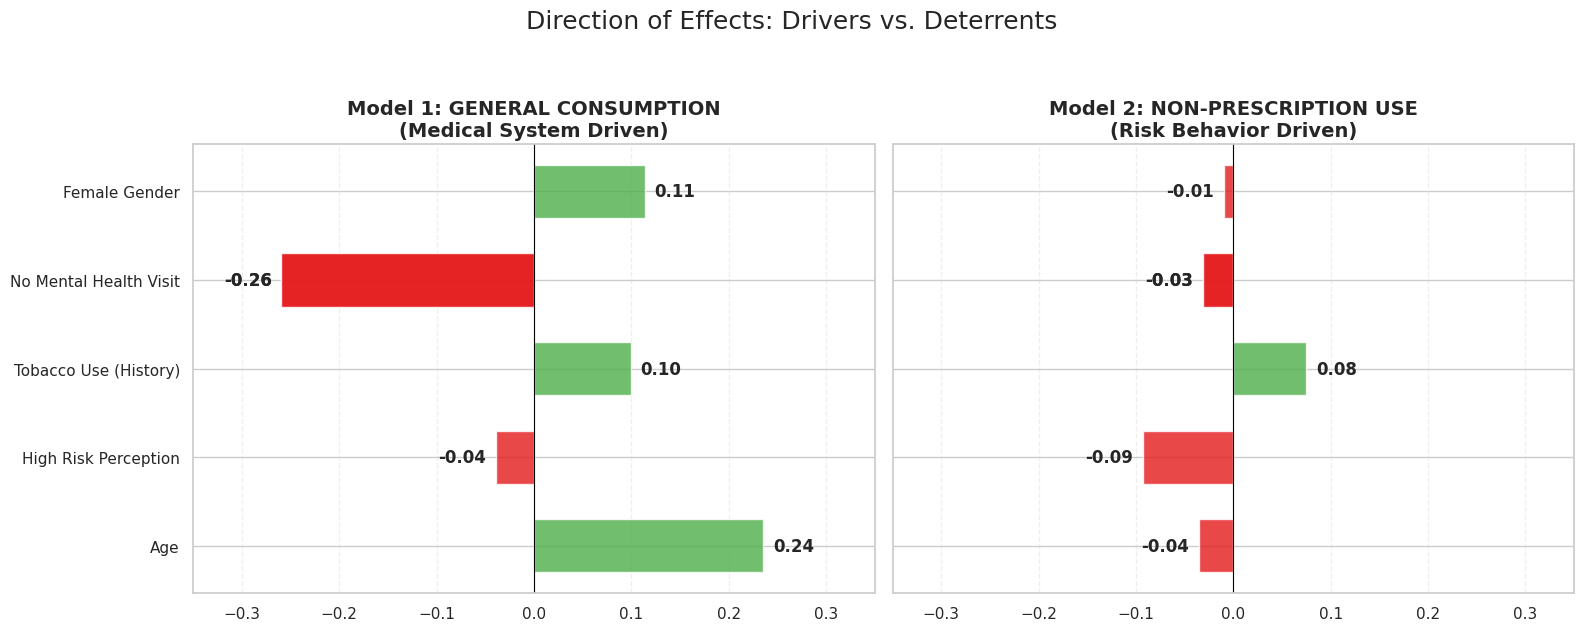

In [21]:
# 1. Prepare correlation data
# We reuse the X matrix and targets to calculate correlation again quickly
df_corr = X.copy()
df_corr['General_Target'] = data['General_Consumption_Target']
df_corr['NonPresc_Target'] = data['No_Prescription_Consumption_Target']

# Select key columns to visualize
cols_to_plot = [
    'Age',
    'Risk_Perception',
    'Tobacco_Consumptiom_Life_1',
    'Mental_Health_Consultation_2.0',
    'Sex_2'
]

# Calculate correlation
corr_matrix = df_corr[cols_to_plot + ['General_Target', 'NonPresc_Target']].corr()
plot_data = corr_matrix[['General_Target', 'NonPresc_Target']].loc[cols_to_plot]

# Rename index for plot
plot_data = plot_data.rename(index={
    'Age': 'Age',
    'Risk_Perception': 'High Risk Perception',
    'Tobacco_Consumptiom_Life_1': 'Tobacco Use (History)',
    'Mental_Health_Consultation_2.0': 'No Mental Health Visit',
    'Sex_2': 'Female Gender'
})

# 2. Plotting Function
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

def plot_div_bars(ax, df, col, title):
    colors = ['#4daf4a' if x >= 0 else '#e41a1c' for x in df[col]]
    bars = ax.barh(df.index, df[col], color=colors, alpha=0.8, height=0.6)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.set_xlim(-0.35, 0.35)

    # Add numbers
    for bar in bars:
        width = bar.get_width()
        pos = width + (0.01 if width >= 0 else -0.01)
        ax.text(pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                va='center', ha='left' if width>=0 else 'right', fontweight='bold')

plot_div_bars(axes[0], plot_data, 'General_Target', 'Model 1: GENERAL CONSUMPTION\n(Medical System Driven)')
plot_div_bars(axes[1], plot_data, 'NonPresc_Target', 'Model 2: NON-PRESCRIPTION USE\n(Risk Behavior Driven)')

plt.suptitle('Direction of Effects: Drivers vs. Deterrents', fontsize=18, y=1.05)
plt.tight_layout()

# Save for GitHub
plt.show()

In [22]:
# ==============================================================================
# MASTER LABEL DICTIONARY
# ==============================================================================
clean_labels = {
    # Demographics
    'Age': 'Age',
    'Sex_2': 'Female Gender',
    # Education
    'Level_of_education_1.0': 'Primary School (Incomplete)',
    'Level_of_education_2.0': 'Primary School (Completed)',
    'Level_of_education_3.0': 'High School (Incomplete)',
    'Level_of_education_4.0': 'High School (Completed)',
    'Level_of_education_5.0': 'University (Incomplete)',
    'Level_of_education_6.0': 'University (Completed)',
    'Level_of_education_7.0': 'No Formal Education',

    # Health Coverage
    'Health_coverage_2': 'Public Healthcare Only',
    'Health_coverage_9': 'Health COverage Unknown',

    # Mental Health Consultations
    'Mental_Health_Consultation_2.0': 'No Mental Health Consultation',

    # Self-Perceived Health
    'Self_perceived_health_1.0': 'Health: Very Poor',
    'Self_perceived_health_2.0': 'Health: Poor',
    'Self_perceived_health_3.0': 'Health: Regular',
    'Self_perceived_health_4.0': 'Health: Good',
    'Self_perceived_health_5.0': 'Health: Very Good',

    # Risk Perception
    'Risk Perception (High)': 'Risk Perception (Scale)',
    'Risk_Perception': 'Risk Perception',

    # Habits
    'Tobacco Use (History)': 'History of Tobacco Use',
    'Tobacco_Consumptiom_Life_1': 'History of Tobacco Use',
    'Alcohol_Consumption_Life_1': 'Alcohol Consumption (Lifetime)',
}

Regenerating charts with CORRECTED labels...


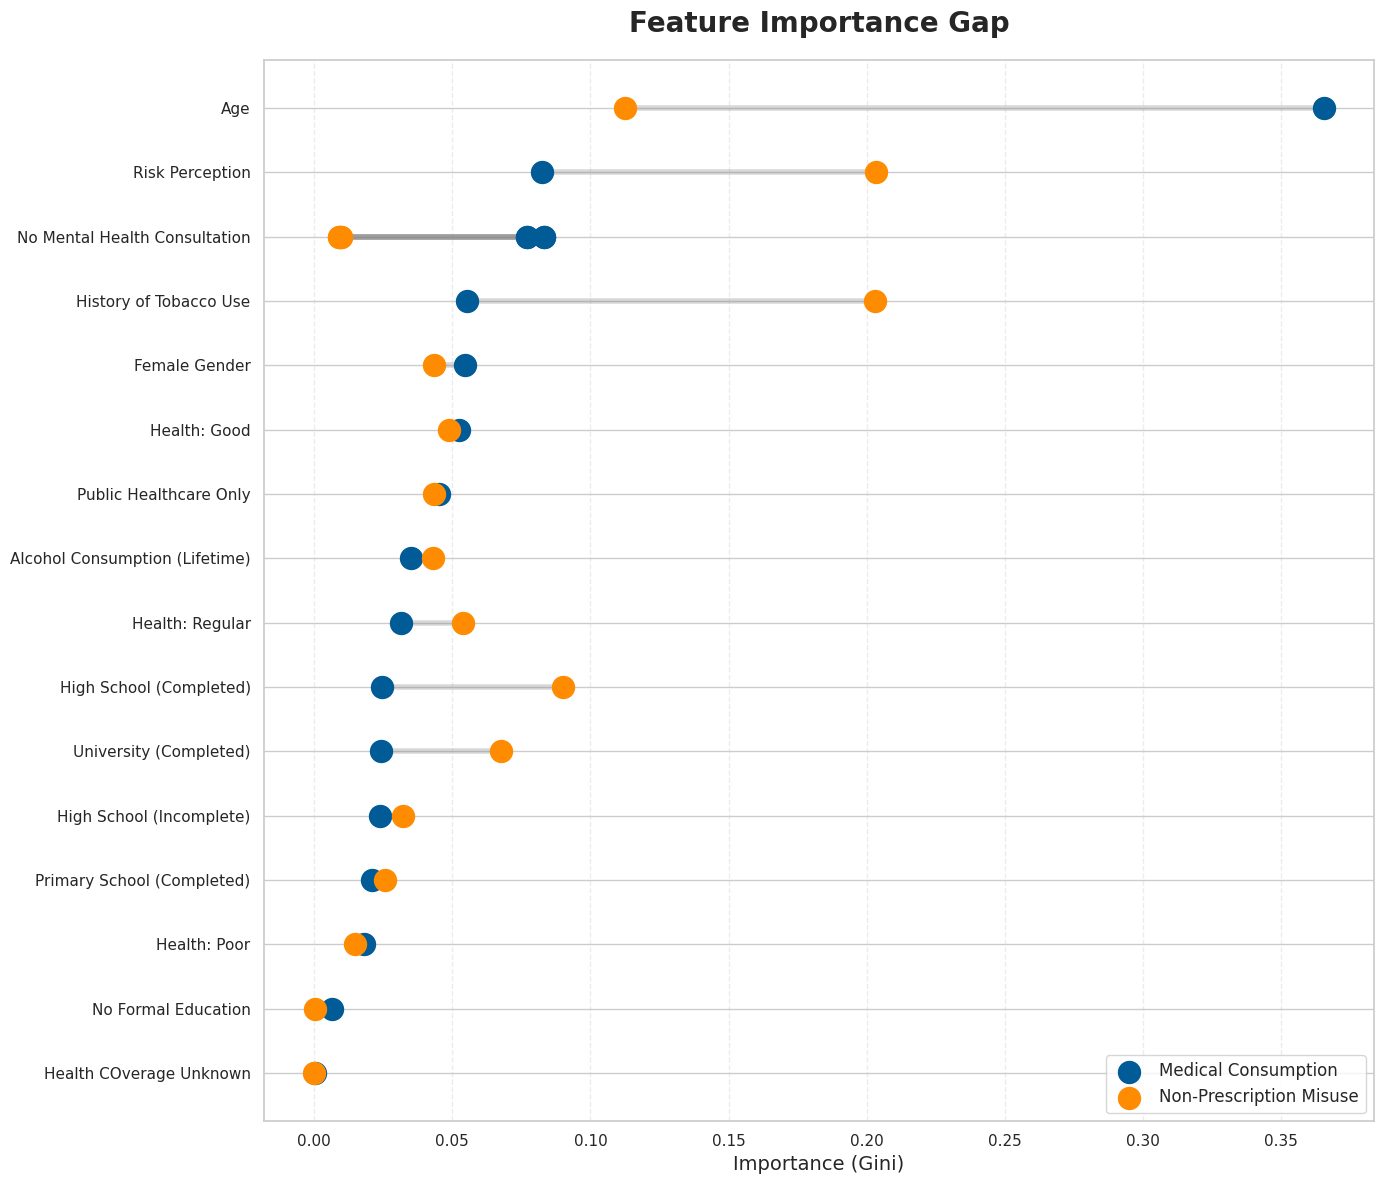

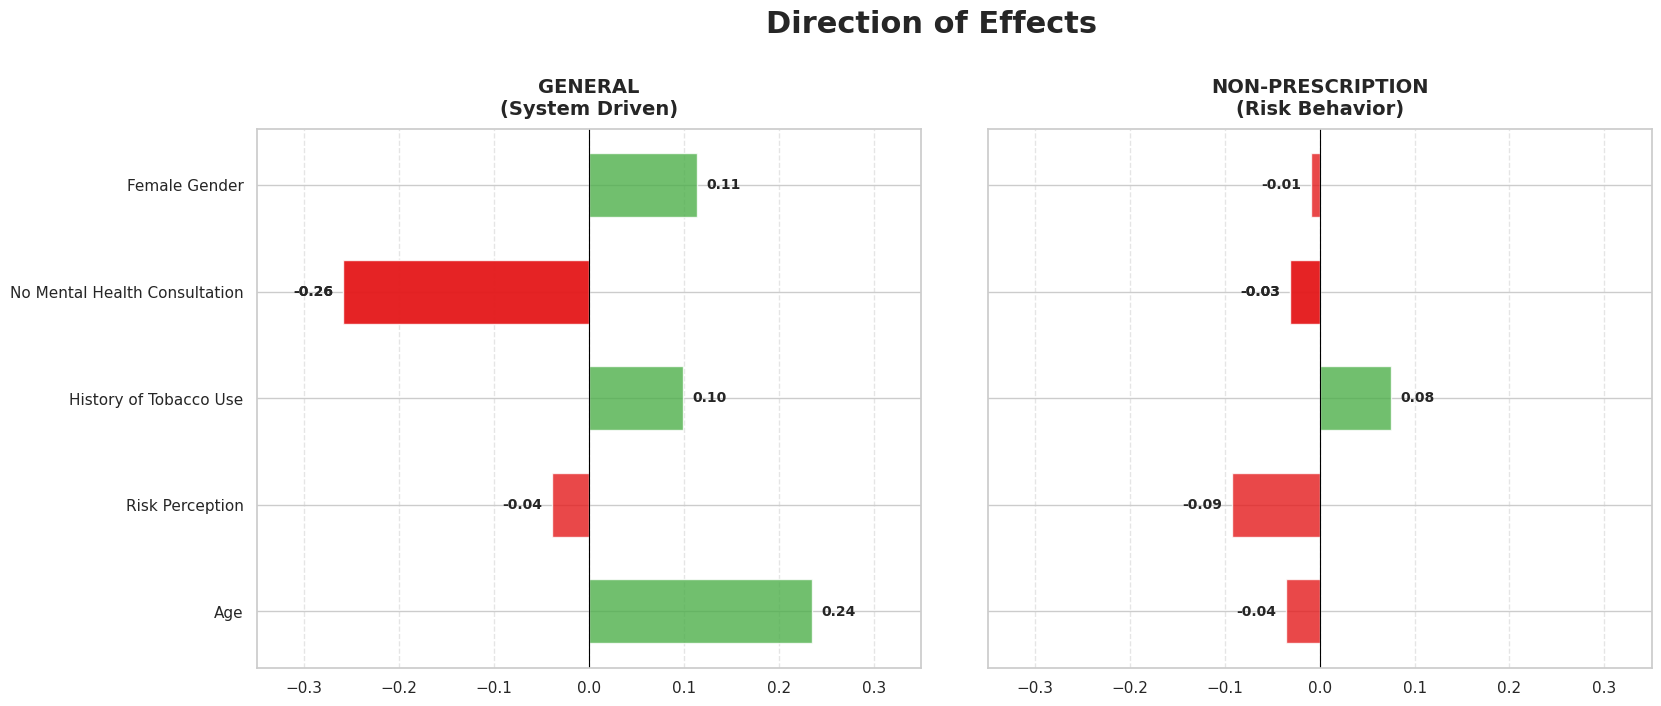

In [24]:
print("Regenerating charts with CORRECTED labels...")

def plot_div_bars_improved(ax, df, col, main_title, sub_title):
    colors = ['#4daf4a' if x >= 0 else '#e41a1c' for x in df[col]]
    bars = ax.barh(df.index, df[col], color=colors, alpha=0.8, height=0.6)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title(f"{main_title}\n({sub_title})", fontsize=14, weight='bold', pad=10)
    ax.grid(axis='x', color='grey', alpha=0.2, linestyle='--')
    ax.set_xlim(-0.35, 0.35)

    for bar in bars:
        width = bar.get_width()
        pos = width + (0.01 if width >= 0 else -0.01)
        ax.text(pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                va='center', ha='left' if width >= 0 else 'right', fontweight='bold', fontsize=10)

# Update Dumbbell Data
df_chart = pd.merge(imp_gen, imp_sin, on='Feature', suffixes=('_Gen', '_NonPre'))
df_chart['Clean_Label'] = df_chart['Feature'].map(clean_labels).fillna(df_chart['Feature'])
df_chart = df_chart.sort_values('Importance_Gen', ascending=True)

# Plot Dumbbell
plt.figure(figsize=(14, 12))
plt.hlines(y=df_chart['Clean_Label'], xmin=df_chart['Importance_NonPre'], xmax=df_chart['Importance_Gen'],
           color='grey', alpha=0.3, linewidth=4, zorder=1)
plt.scatter(df_chart['Importance_Gen'], df_chart['Clean_Label'],
            color='#005b96', alpha=1, s=250, label='Medical Consumption', zorder=3)
plt.scatter(df_chart['Importance_NonPre'], df_chart['Clean_Label'],
            color='#ff8c00', alpha=1, s=250, label='Non-Prescription Misuse', zorder=3)

plt.title('Feature Importance Gap', fontsize=20, weight='bold', pad=20)
plt.xlabel('Importance (Gini)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(axis='x', color='grey', alpha=0.15, linestyle='--')
plt.tight_layout()
plt.savefig('dumbbell_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Diverging Bars
df_corr = X.copy()
df_corr['General_Target'] = data['General_Consumption_Target']
df_corr['NonPre_Target'] = data['No_Prescription_Consumption_Target']

cols = ['Age', 'Risk_Perception', 'Tobacco_Consumptiom_Life_1', 'Mental_Health_Consultation_2.0', 'Sex_2']
corr_matrix = df_corr[cols + ['General_Target', 'NonPre_Target']].corr()
plot_data = corr_matrix[['General_Target', 'NonPre_Target']].loc[cols]

# Corrected line to map and fill index labels
plot_data.index = [clean_labels.get(idx, idx) for idx in plot_data.index]

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
plt.subplots_adjust(wspace=0.1)

plot_div_bars_improved(axes[0], plot_data, 'General_Target', 'GENERAL', 'System Driven')
plot_div_bars_improved(axes[1], plot_data, 'NonPre_Target', 'NON-PRESCRIPTION', 'Risk Behavior')

plt.suptitle('Direction of Effects', fontsize=22, weight='bold', y=1.05)
plt.savefig('diverging_bars.png', dpi=300, bbox_inches='tight')
plt.show()